In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

In [ ]:
from keras.utils.generic_utils import Progbar
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU, Reshape, Conv2DTranspose, Flatten
from keras.layers.core import Activation
from keras.optimizers import Adam
import keras.backend as K
import math, cv2
import numpy as np
#import cupy as np
import os

from keras.models import model_from_json

In [3]:
# Generator
class Generator(object):
    def __init__(self, input_dim, image_shape):
        INITIAL_CHANNELS = 128
        # 生成した画像の1/4をsizeとする
        INITIAL_SIZE = 25

        inputs = Input((input_dim,))
        fc1 = Dense(input_dim=input_dim, units=INITIAL_CHANNELS * INITIAL_SIZE * INITIAL_SIZE)(inputs)
        fc1 = BatchNormalization()(fc1)
        fc1 = LeakyReLU(0.2)(fc1)
        fc2 = Reshape((INITIAL_SIZE, INITIAL_SIZE, INITIAL_CHANNELS),
                      input_shape=(INITIAL_CHANNELS * INITIAL_SIZE * INITIAL_SIZE,))(fc1)
        up1 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(fc2)
        conv1 = Conv2D(64, (3, 3), padding='same')(up1)
        conv1 = BatchNormalization()(conv1)
        conv1 = Activation('relu')(conv1)
        up2 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv1)
        conv2 = Conv2D(image_shape[2], (5, 5), padding='same')(up2)
        outputs = Activation('tanh')(conv2)

        self.model = Model(inputs=[inputs], outputs=[outputs])

    def get_model(self):
        return self.model

In [4]:
# Discriminator
class Discriminator(object):
    def __init__(self, input_shape):
        inputs = Input(input_shape)
        conv1 = Conv2D(64, (5, 5), padding='same')(inputs)
        conv1 = LeakyReLU(0.2)(conv1)
        pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
        conv2 = Conv2D(128, (5, 5), padding='same')(pool1)
        conv2 = LeakyReLU(0.2)(conv2)
        pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
        fc1 = Flatten()(pool2)
        fc1 = Dense(1)(fc1)
        outputs = Activation('sigmoid')(fc1)

        self.model = Model(inputs=[inputs], outputs=[outputs])

    def get_model(self):
        return self.model

In [9]:
# DCGAN
class DCGAN(object):
    def __init__(self, input_dim, image_shape):
        self.input_dim = input_dim
        self.d = Discriminator(image_shape).get_model()
        self.g = Generator(input_dim, image_shape).get_model()

    def compile(self, g_optim, d_optim):
        self.d.trainable = False
        self.dcgan = Sequential([self.g, self.d])
        self.dcgan.compile(loss='binary_crossentropy', optimizer=g_optim)
        self.d.trainable = True
        self.d.compile(loss='binary_crossentropy', optimizer=d_optim)

    def train(self, epochs, batch_size, X_train):
        g_losses = []
        d_losses = []
        for epoch in range(epochs):
            np.random.shuffle(X_train)
            n_iter = X_train.shape[0] // batch_size
            progress_bar = Progbar(target=n_iter)
            for index in range(n_iter):
                noise = np.random.uniform(-1, 1, size=(batch_size, self.input_dim))

                image_batch = X_train[index * batch_size:(index + 1) * batch_size]
                for i in range(batch_size):
                    if np.random.random() > 0.5:
                        image_batch[i] = np.fliplr(image_batch[i])
                    if np.random.random() > 0.5:
                        image_batch[i] = np.flipud(image_batch[i])
                generated_images = self.g.predict(noise, verbose=0)

                X = np.concatenate((image_batch, generated_images))
                y = np.array([1] * batch_size + [0] * batch_size)

                # training discriminator
                d_loss = self.d.train_on_batch(X, y)

                # training generator
                g_loss = self.dcgan.train_on_batch(noise, np.array([1] * batch_size))

                progress_bar.update(index, values=[('g', g_loss), ('d', d_loss)])
            g_losses.append(g_loss)
            d_losses.append(d_loss)
            
            if (epoch + 1) % 1 == 0:
                image = self.combine_images(generated_images)
                image = (image + 1) / 2.0 * 255.0
                cv2.imwrite('./results/' + str(epoch) + ".png", image)
            print('\nEpoch' + str(epoch) + " end")

            if (epoch + 1) % 10 == 0:
                self.g.save('./weights/generator_' + str(epoch) + '.h5', True)
                self.d.save('./weights/discriminator_' + str(epoch) + '.h5', True)
        return g_losses, d_losses

    def load_weights(self, g_weight, d_weight):
        self.g.load_weights(g_weight)
        self.d.load_weights(d_weight)

    def combine_images(self, generated_images):
        num = generated_images.shape[0]
        width = int(math.sqrt(num))
        height = int(math.ceil(float(num) / width))
        shape = generated_images.shape[1:4]
        image = np.zeros((height * shape[0], width * shape[1], shape[2]),
                         dtype=generated_images.dtype)
        for index, img in enumerate(generated_images):
            i = int(index / width)
            j = index % width
            image[i * shape[0]:(i + 1) * shape[0], j * shape[1]:(j + 1) * shape[1], :] = img[:, :, :]
        return image

In [10]:
# AnoGAN
def sum_of_residual(y_true, y_pred):
    return K.sum(K.abs(y_true - y_pred))


class ANOGAN(object):
    def __init__(self, input_dim, g):
        self.input_dim = input_dim
        self.g = g
        g.trainable = False
        # Input layer cann't be trained. Add new layer as same size & same distribution
        anogan_in = Input(shape=(input_dim,))
        g_in = Dense((input_dim), activation='tanh', trainable=True)(anogan_in)
        g_out = g(g_in)
        self.model = Model(inputs=anogan_in, outputs=g_out)
        self.model_weight = None

    def compile(self, optim):
        self.model.compile(loss=sum_of_residual, optimizer=optim)
        K.set_learning_phase(0)

    def compute_anomaly_score(self, x, iterations=300):
        z = np.random.uniform(-1, 1, size=(1, self.input_dim))

        # learning for changing latent
        loss = self.model.fit(z, x, batch_size=1, epochs=iterations, verbose=0)
        loss = loss.history['loss'][-1]
        similar_data = self.model.predict_on_batch(z)

        return loss, similar_data

In [11]:
# train
if __name__ == '__main__':
    batch_size = 32
    epochs = 500
    input_dim = 100
    g_optim = Adam(lr=0.0001, beta_1=0.5, beta_2=0.999)
    d_optim = Adam(lr=0.0001, beta_1=0.5, beta_2=0.999)

    import cv2
    import numpy as np
    import os
    from keras.preprocessing.image import img_to_array, load_img

    TRAIN_IMAGE_PATH = "./cats/"
    #x_IMAGE_PATH = "./Floc_Image_rot/s24_196_under/test/"
    #y_IMAGE_PATH = "./Floc_Image_rot/s24_196_over/"

    img_list = os.listdir(TRAIN_IMAGE_PATH)
    x_train = []
    for img in img_list:
        img = img_to_array(load_img(TRAIN_IMAGE_PATH + img, grayscale=False, target_size=(input_dim, input_dim, 3)))
        img = (img.astype(np.float32) - 127.5) / 127.5
        x_train.append(img)
    x_train = np.array(x_train)

    input_shape = x_train[0].shape

    # train generator & discriminator
    dcgan = DCGAN(input_dim, input_shape)
    
    #dcgan.load_weights('/Users/takaaki/Desktop/generator_1.h5',
    #                                    '/Users/takaaki/Desktop/discriminator_1.h5')
    
    dcgan.compile(g_optim, d_optim)
    g_losses, d_losses = dcgan.train(epochs, batch_size, x_train)
    with open('loss.csv', 'w') as f:
        for g_loss, d_loss in zip(g_losses, d_losses):
            f.write(str(g_loss) + ',' + str(d_loss) + '\n')



124/125 [============================>.] - ETA: 0s - g: 2.3683 - d: 0.1287
Epoch0 end
124/125 [============================>.] - ETA: 0s - g: 9.7800 - d: 0.0453
Epoch1 end
124/125 [============================>.] - ETA: 0s - g: 14.6971 - d: 0.0372
Epoch2 end
124/125 [============================>.] - ETA: 0s - g: 16.1181 - d: 0.0030
Epoch3 end
124/125 [============================>.] - ETA: 0s - g: 16.1181 - d: 9.9469e-04
Epoch4 end
124/125 [============================>.] - ETA: 0s - g: 16.1181 - d: 6.8467e-04
Epoch5 end
124/125 [============================>.] - ETA: 0s - g: 16.0755 - d: 0.0520
Epoch6 end
124/125 [============================>.] - ETA: 0s - g: 16.1181 - d: 0.0064
Epoch7 end
124/125 [============================>.] - ETA: 0s - g: 10.3201 - d: 0.4184
Epoch8 end
124/125 [============================>.] - ETA: 0s - g: 1.6491 - d: 0.4870
Epoch9 end
124/125 [============================>.] - ETA: 0s - g: 0.8972 - d: 0.1294
Epoch10 end
124/125 [============================>

124/125 [============================>.] - ETA: 0s - g: 2.1044 - d: 0.1563
Epoch94 end
124/125 [============================>.] - ETA: 0s - g: 4.0409 - d: 0.2297
Epoch95 end
124/125 [============================>.] - ETA: 0s - g: 3.0221 - d: 0.1566
Epoch96 end
124/125 [============================>.] - ETA: 0s - g: 2.6120 - d: 0.2069
Epoch97 end
124/125 [============================>.] - ETA: 0s - g: 3.9794 - d: 0.1643
Epoch98 end
124/125 [============================>.] - ETA: 0s - g: 4.1311 - d: 0.1644
Epoch99 end
124/125 [============================>.] - ETA: 0s - g: 4.0262 - d: 0.0913
Epoch100 end
124/125 [============================>.] - ETA: 0s - g: 3.0943 - d: 0.1402
Epoch101 end
124/125 [============================>.] - ETA: 0s - g: 3.1683 - d: 0.0736
Epoch102 end
124/125 [============================>.] - ETA: 0s - g: 4.5526 - d: 0.0905
Epoch103 end
124/125 [============================>.] - ETA: 0s - g: 2.1208 - d: 0.1024
Epoch104 end
124/125 [============================>

124/125 [============================>.] - ETA: 0s - g: 2.0437 - d: 0.0817
Epoch187 end
124/125 [============================>.] - ETA: 0s - g: 1.5232 - d: 0.0596
Epoch188 end
124/125 [============================>.] - ETA: 0s - g: 0.6885 - d: 0.0147
Epoch189 end
124/125 [============================>.] - ETA: 0s - g: 3.6923 - d: 0.1001
Epoch190 end
124/125 [============================>.] - ETA: 0s - g: 6.6957 - d: 0.1065
Epoch191 end
124/125 [============================>.] - ETA: 0s - g: 2.7207 - d: 0.0653
Epoch192 end
124/125 [============================>.] - ETA: 0s - g: 2.8049 - d: 0.0538
Epoch193 end
124/125 [============================>.] - ETA: 0s - g: 3.1245 - d: 0.0694
Epoch194 end
124/125 [============================>.] - ETA: 0s - g: 3.7007 - d: 0.1135
Epoch195 end
124/125 [============================>.] - ETA: 0s - g: 1.6763 - d: 0.0529
Epoch196 end
124/125 [============================>.] - ETA: 0s - g: 2.8564 - d: 0.0755
Epoch197 end
124/125 [=======================

124/125 [============================>.] - ETA: 0s - g: 2.6549 - d: 0.0435
Epoch280 end
124/125 [============================>.] - ETA: 0s - g: 0.6701 - d: 0.0293
Epoch281 end
124/125 [============================>.] - ETA: 0s - g: 1.6529 - d: 0.0507
Epoch282 end
124/125 [============================>.] - ETA: 0s - g: 1.7238 - d: 0.0503
Epoch283 end
124/125 [============================>.] - ETA: 0s - g: 3.8371 - d: 0.0725
Epoch284 end
124/125 [============================>.] - ETA: 0s - g: 1.8094 - d: 0.0361
Epoch285 end
124/125 [============================>.] - ETA: 0s - g: 1.6502 - d: 0.0294
Epoch286 end
124/125 [============================>.] - ETA: 0s - g: 6.1011 - d: 0.2196
Epoch287 end
124/125 [============================>.] - ETA: 0s - g: 0.7272 - d: 0.0300
Epoch288 end
124/125 [============================>.] - ETA: 0s - g: 1.4277 - d: 0.0549
Epoch289 end
124/125 [============================>.] - ETA: 0s - g: 2.4819 - d: 0.0548
Epoch290 end
124/125 [=======================

124/125 [============================>.] - ETA: 0s - g: 0.5507 - d: 0.0145
Epoch373 end
124/125 [============================>.] - ETA: 0s - g: 0.9580 - d: 0.0160
Epoch374 end
124/125 [============================>.] - ETA: 0s - g: 0.2821 - d: 0.0145
Epoch375 end
124/125 [============================>.] - ETA: 0s - g: 0.0494 - d: 0.0054
Epoch376 end
124/125 [============================>.] - ETA: 0s - g: 0.6428 - d: 0.0203
Epoch377 end
124/125 [============================>.] - ETA: 0s - g: 2.1568 - d: 0.0426
Epoch378 end
124/125 [============================>.] - ETA: 0s - g: 0.1710 - d: 0.0119
Epoch379 end
124/125 [============================>.] - ETA: 0s - g: 1.9350 - d: 0.0095
Epoch380 end
124/125 [============================>.] - ETA: 0s - g: 0.2061 - d: 0.0098
Epoch381 end
124/125 [============================>.] - ETA: 0s - g: 0.1841 - d: 0.0121
Epoch382 end
124/125 [============================>.] - ETA: 0s - g: 0.3247 - d: 0.0143
Epoch383 end
124/125 [=======================

124/125 [============================>.] - ETA: 0s - g: 2.2329 - d: 0.0974
Epoch466 end
124/125 [============================>.] - ETA: 0s - g: 0.4303 - d: 0.0234
Epoch467 end
124/125 [============================>.] - ETA: 0s - g: 0.0871 - d: 0.0086
Epoch468 end
124/125 [============================>.] - ETA: 0s - g: 1.1585 - d: 0.0465
Epoch469 end
124/125 [============================>.] - ETA: 0s - g: 0.8920 - d: 0.0235
Epoch470 end
124/125 [============================>.] - ETA: 0s - g: 2.9209 - d: 0.1706
Epoch471 end
124/125 [============================>.] - ETA: 0s - g: 0.5976 - d: 0.0502
Epoch472 end
124/125 [============================>.] - ETA: 0s - g: 1.6028 - d: 0.1003
Epoch473 end
124/125 [============================>.] - ETA: 0s - g: 0.4878 - d: 0.0292
Epoch474 end
124/125 [============================>.] - ETA: 0s - g: 0.6381 - d: 0.0491
Epoch475 end
124/125 [============================>.] - ETA: 0s - g: 0.2747 - d: 0.0185
Epoch476 end
124/125 [=======================

In [8]:
pwd

'C:\\Users\\Takaaki Ishii\\OneDrive - 中央大学\\python\\AnoGAN'

In [ ]:
# test
K.set_learning_phase(1)


def denormalize(X):
    return ((X + 1.0) / 2.0 * 255.0).astype(dtype=np.uint8)


# test
if __name__ == '__main__':
    iterations = 50
    
    # 画像サイズ
    input_dim = 200
    anogan_optim = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
    
    y_IMAGE_PATH = "./Floc_Image/s24_190_over/"



    img_list = os.listdir(y_IMAGE_PATH)
    with open('./results/img_name.txt', 'a') as f:
        f.write(str(img_list) + '\n')

    y_test = []
    for img in img_list:
        img = img_to_array(load_img(y_IMAGE_PATH + img, grayscale=True, target_size=(input_dim, input_dim, 1)))
        # -1から1の範囲に正規化
        img = (img.astype(np.float32) - 127.5) / 127.5
        y_test.append(img)
    y_test = np.array(y_test)
    

    # load weights
    dcgan = DCGAN(input_dim, input_shape)
    dcgan.load_weights('./weights/generator_1099.h5',
                       './weights/discriminator_1099.h5')


    for i, test_img in enumerate(y_test):
        test_img = test_img[np.newaxis, :, :, :]
        anogan = ANOGAN(input_dim, dcgan.g)
        anogan.compile(anogan_optim)
        anomaly_score, generated_img = anogan.compute_anomaly_score(test_img, iterations)

        generated_img = denormalize(generated_img)
        imgs = np.concatenate((denormalize(test_img[0]), generated_img[0]), axis=1)
        cv2.imwrite('predict' + os.sep + str(int(anomaly_score)) + '_' + str(i) + '.png', imgs)
        print(str(i) + ' %.2f' % anomaly_score)

        with open('./results/y_test_score.txt', 'a') as f:
            f.write(str(anomaly_score) + '\n')

0 4990.86
1 1273.79
2 1253.92
3 1251.02
4 1261.82
5 1356.76
6 1793.78
7 1390.50
8 1896.80
9 1261.25
10 1850.84
11 1809.46
12 1999.98
13 1593.14
14 1382.47
15 2100.19
16 2109.02
17 1595.07
18 1783.67
19 1606.71
20 1389.31
21 2098.65
22 1548.03
23 1954.67
24 1887.63
25 1795.28
26 2039.39
27 2165.80
28 2491.45
29 1985.45
30 2367.50
31 2012.57
32 2158.92
33 2321.25
34 1846.99
35 1607.15
36 1982.45
37 2132.83
38 2018.97
39 1558.47
40 1909.83
41 2263.27
42 1929.93
43 1979.20
44 2370.20
45 1735.94
46 2144.97
47 2283.37
48 1327.43
49 1790.36
50 1464.33
51 1378.78
52 1524.95
53 1735.14
54 1435.64
55 1678.83
56 1658.58
57 2049.35
58 1713.57
59 1676.12
60 1449.68
61 1557.98
62 1745.87
63 1821.91
64 1793.03
65 1700.45
66 1824.99
67 1705.52
68 1472.30
69 1704.36
70 1754.99
71 1451.41
72 1790.17
73 1929.37
74 1699.46
75 2192.24
76 1831.91
77 2249.13
78 1647.36
79 2094.04
80 1853.02
81 1839.46
82 1756.22
83 1616.94
84 1600.31
85 1306.50
86 1860.30
87 1384.79
88 1717.37
89 1635.78
90 1501.01
91 1927.2

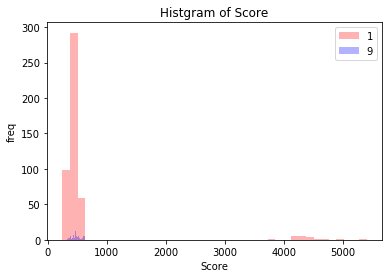

In [12]:
if __name__ == '__main__':
    # plot histgram
    import matplotlib.pyplot as plt
    import csv

    x = []
    with open('C:/Users/Takaaki Ishii/Desktop/results/y_train_score.txt', 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            row = int(float(row[0]))
            x.append(row)
    y = []
    with open('C:/Users/Takaaki Ishii/Desktop/results/y_test_score.txt', 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            row = int(float(row[0]))
            y.append(row)

    plt.title("Histgram of Score")
    plt.xlabel("Score")
    plt.ylabel("freq")
    plt.hist(x, bins=40, alpha=0.3, histtype='stepfilled', color='r', label="1")
    plt.hist(y, bins=40, alpha=0.3, histtype='stepfilled', color='b', label='9')
    plt.legend(loc=1)
    plt.savefig("C:/Users/Takaaki Ishii/Desktop/results/histgram.png")
    plt.show()
